In [10]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools

import Base: show

In [2]:
function filtering_model()
    model = Model()
    
    x_prior_mean = datavar(model, :x_prior_mean, Dirac{Float64})
    x_prior_var  = datavar(model, :x_prior_var, Dirac{Float64})
    
    _, x_prior = make_node(model, NormalMeanVariance, AutoVar(:x_prior), x_prior_mean, x_prior_var)
    
    c = constvar(model, :c, 1.0)
    
    _, x = make_node(model, +, AutoVar(:x), x_prior, c)
    
    noise_mean = constvar(model, :noise_mean, 0.0)
    noise_var  = constvar(model, :noise_var, 200.0)
    
    _, noise = make_node(model, NormalMeanVariance, AutoVar(:noise), noise_mean, noise_var)
    
    y = datavar(model, :y, Dirac{Float64})
    
    _ = make_node(model, +, y, x, noise)
    
    activate!(model)
    
    return x_prior_mean, x_prior_var, x, y
end

function filtering(data)
    N = length(data)
    
    x_prior_mean, x_prior_var, x, y = filtering_model()
    
    marginals = Vector{NormalMeanVariance{Float64}}()
    
    subscription = subscribe!(getmarginal(x), (t) -> begin
        update!(x_prior_mean, mean(t))
        update!(x_prior_var, var(t))

        push!(marginals, getdata(t))
    end)
    
    update!(x_prior_mean, 0.0)
    update!(x_prior_var, 100000.0)
    
    for d in data
        update!(y, d)
    end
    
    unsubscribe!(subscription)
    
    return marginals
end

filtering (generic function with 1 method)

In [3]:
N = 600
data = collect(1:N) + sqrt(200.0) * randn(N);

In [4]:
@time filtering(data); # Initial compilation

  3.644662 seconds (9.11 M allocations: 487.569 MiB, 4.21% gc time)


In [5]:
@time filtering(data); # Subsequent runs

  0.001839 seconds (32.30 k allocations: 1.612 MiB)


In [6]:
@btime filtering($data); # Performance benchmark

  1.231 ms (32302 allocations: 1.61 MiB)


In [7]:
using Plots

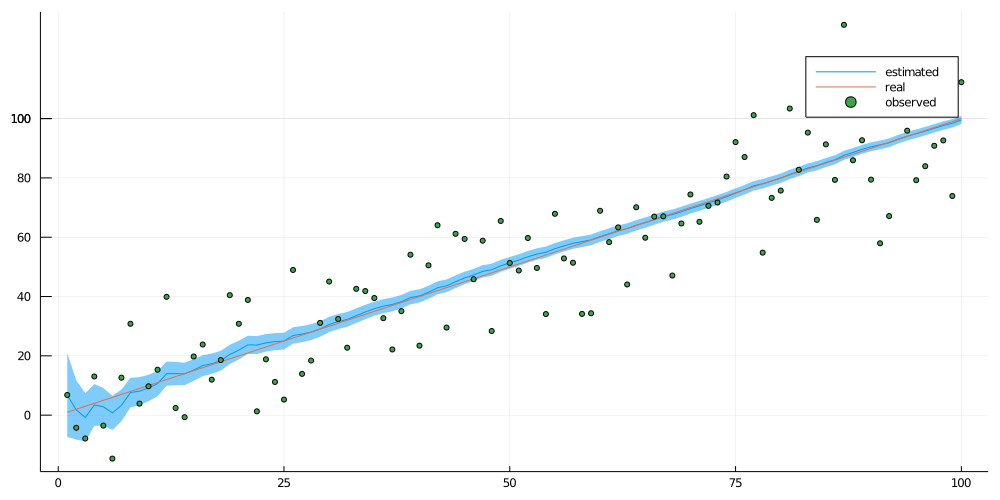

In [8]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = filtering(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))

In [9]:
filtering(data)

600-element Array{NormalMeanVariance{Float64},1}:
 NormalMeanVariance{Float64}(μ=3.7464932313716792, v=199.6007984031936)
 NormalMeanVariance{Float64}(μ=15.380367762829664, v=99.9000999000999)
 NormalMeanVariance{Float64}(μ=8.395406713046631, v=66.62225183211193)
 NormalMeanVariance{Float64}(μ=7.518745358622753, v=49.97501249375312)
 NormalMeanVariance{Float64}(μ=9.082258791419594, v=39.98400639744102)
 NormalMeanVariance{Float64}(μ=4.32884028095891, v=33.322225924691764)
 NormalMeanVariance{Float64}(μ=3.099084457824645, v=28.563267637817763)
 NormalMeanVariance{Float64}(μ=6.021479317739051, v=24.99375156210947)
 NormalMeanVariance{Float64}(μ=8.650965752354214, v=22.21728504776716)
 NormalMeanVariance{Float64}(μ=9.44019659451948, v=19.99600079984003)
 NormalMeanVariance{Float64}(μ=10.565833483755668, v=18.17851299763679)
 NormalMeanVariance{Float64}(μ=13.080951915776168, v=16.6638893517747)
 NormalMeanVariance{Float64}(μ=15.858285983454373, v=15.382248884786952)
 ⋮
 NormalMeanVariance{